In [89]:
# Import packages
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset 
from PIL import Image
from torch.utils.data.dataloader import default_collate

# CONFIG #
# Adapted from Assignment 2 codebase

# TRAINING SETTINGS
NUM_EPOCHS = 5


# LEARNING RATE SETTINGS
BASE_LR = 0.01
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
DATA_DIR = 'InDL' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 50 # originally 10


# GPU SETTINGS
#TORCH_DEVICE = 'mps:0' # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
device = torch.device("mps")
GPU_MODE = 1 # set to 1 if want to run on gpu.

use_gpu = GPU_MODE

In [90]:
# Load InDL label dictionary
import pickle 

with open('/Users/ellacho/Documents/NB240/indl-dataset-main/InDL_dict.p', 'rb') as f:
    full_dict = pickle.load(f)

In [91]:
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import glob
import os

# Paste InDL custom dataset
class InDL(Dataset):
  def __init__(self, split = "train", transform=None, target_transform=None):

    self.data_dir = "/Users/ellacho/Documents/NB240/indl-dataset-main/data"

    self.transform = transform
    self.split = split
    self.target_transform = target_transform

    # Define class dictionary
    self.class_dict = {i: f"class[{i}]" for i in range(0, 1)}

    # Create empty list for storing filepath and image label
    self.items = []

    # Define logic to find training data and fill the dict

    if self.split == 'train':
       for folder in glob.glob(f"{self.data_dir}/train/**/"):
          # Iterate through different .png files in each dataset folder
          for file in os.listdir(folder):
            if file.startswith("."):  # skip .DS_Store and other hidden files
              continue
          
            image_name = file
            image_label = full_dict[image_name]
            image_path = os.path.join(folder, image_name)

            self.items.append((image_path, image_label))

    elif self.split == 'val':
       for folder in glob.glob(f"{self.data_dir}/test/**/"):
          # Iterate through different .png files in each dataset folder
          for file in os.listdir(folder):
            if file.startswith("."):  # skip .DS_Store and other hidden files
              continue
          
            image_name = file
            image_label = full_dict[image_name]
            image_path = os.path.join(folder, image_name)

            self.items.append((image_path, image_label))

    print(f"Loaded {len(self.items)} images for {self.split} dataset.")

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):

    # Added additional code from generative AI (prompt: fix bug "TypeError: Variable data has to be a tensor, but got list.")
    img_path, label = self.items[idx]
    image = Image.open(img_path).convert("RGB")

    if self.transform:
        image = self.transform(image)  # Ensure transform outputs a tensor
    else:
        image = transforms.ToTensor()(image)

    label = torch.tensor(label, dtype=torch.long) # Ensure labels are integers, not lists or floats

    return image, label

In [92]:
# Define transformations for training and validation
# Adapted from Assignment 2 codebase

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [93]:
# Define training and validation datasets
dsets = {}

for split in ['train', 'val']:
    dsets[split] = InDL(split, data_transforms[split])

Loaded 8000 images for train dataset.
Loaded 2000 images for val dataset.


In [94]:
# Get dataset sizes
dset_sizes = {'train': len(dsets['train']), 'val': len(dsets['val'])}

# Define DataLoaders
dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=default_collate),
    'val': DataLoader(dsets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=default_collate)
}

In [95]:
from collections import Counter
# Count label frequencies in your dataset
label_counts = Counter(label for _, label in dsets['train'].items)
total = sum(label_counts.values())

# Inverse frequency weighting
weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print(class_weights)

tensor([1.4309, 3.3209], device='mps:0')


In [96]:
# Import pertinent packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [97]:
# Define model
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model.to(device)
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter = 0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for data in dset_loaders[phase]:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Set gradient to zero to delete history of computations in previous epoch
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # Compute loss
                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch
                if counter % 10 == 0:
                    print(f"Reached batch iteration {counter}")

                counter += 1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update running loss and accuracy
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size for total loss
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.float() / dset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            accuracies[phase].append(epoch_acc.item())  # Store accuracy for the phase
            losses[phase].append(epoch_loss)  # Store loss for the phase

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                print(f'New best accuracy = {best_acc:.4f}')

        # Step the learning rate scheduler
        # lr_scheduler.step()
        optimizer = lr_scheduler(optimizer, epoch)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print('Returning the best model')

    return best_model, accuracies, losses


In [98]:
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY, DECAY_WEIGHT=0.1):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print(f"LR is set to {lr}")

    # Update only the trainable parameters
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


In [124]:
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn

# Load ResNet50 model architecture
model_ft = models.resnet18(pretrained=False)  # Start from scratch, don't load the weights


# Modify to match CIFAR conv layer
model_ft.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_ft.maxpool = torch.nn.Identity()

# Change final layer to match CIFAR and pre InDL
model_ft.fc = torch.nn.Linear(512, 10)

# Load the previously trained ResNet18 weights (from your model)
# SNS = '/Users/ellacho/Documents/NB240/shapenetsem_5.pt'
# CIFAR10 = '/Users/ellacho/Documents/NB240/CIFAR10_train_val_6.pt'
preInDL = '/Users/ellacho/Documents/NB240/indl-dataset-main/InDL_train_val_4.pt'

pretrained_weights = torch.load(preInDL)

# Load the weights into the model

# The general approach is to load the weights of common layers and skip the final layer (fc).
model_ft.load_state_dict(pretrained_weights, strict=False)

# Freeze all layers except the final classification layer
for param in model_ft.parameters():
    param.requires_grad = False  # Freeze all layers

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),            # Dropout with 50% drop rate
    nn.Linear(num_ftrs, 2)        # Your number of classes (e.g., 2)
)

# Loss function
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Move model to GPU if available
if use_gpu:
    model_ft.to(device)
    criterion.to(device)

# Set the optimizer to only update the parameters of the new classification head (model.fc)
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=5e-4)  # Only optimize the last layer

In [100]:
# # CIFAR
# print("Loaded weights:")
# for name, param in pretrained_weights.items():
#     print(name, param.shape)

In [101]:
# # SNS
# print("Loaded weights:")
# for name, param in pretrained_weights.items():
#     print(name, param.shape)

In [102]:
# print("Model fc weight mean:", model_ft.fc.weight.mean())

In [103]:
# # SNS
# print("Model fc weight mean:", model_ft.fc.weight.mean())

In [125]:
# Run the functions and save the best model in the function model_ft.
model_ft_3, accuracies_3, losses_3 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

----------
Epoch 0/4
----------
LR is set to 0.01
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
train Loss: 0.8170 Acc: 0.5045
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
val Loss: 0.7004 Acc: 0.7070
New best accuracy = 0.7070
LR is set to 0.01
----------
Epoch 1/4
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90


In [105]:
# # Export full_dict
# import pickle

# # # Save it as a pickle file
# # with open('sns_accuracies.p', 'wb') as f:
# #     pickle.dump(accuracies, f)

# # with open('sns_losses.p', 'wb') as f:
# #     pickle.dump(losses, f)

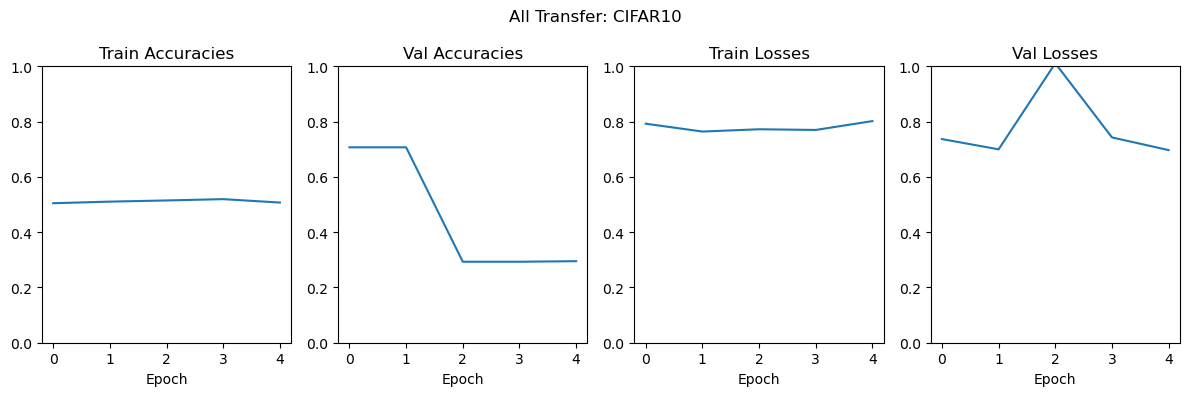

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("All Transfer: CIFAR10", fontsize=12) 

ax[0].plot(accuracies['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("AllTransfer_CIFAR10.png", dpi=300)

plt.show()

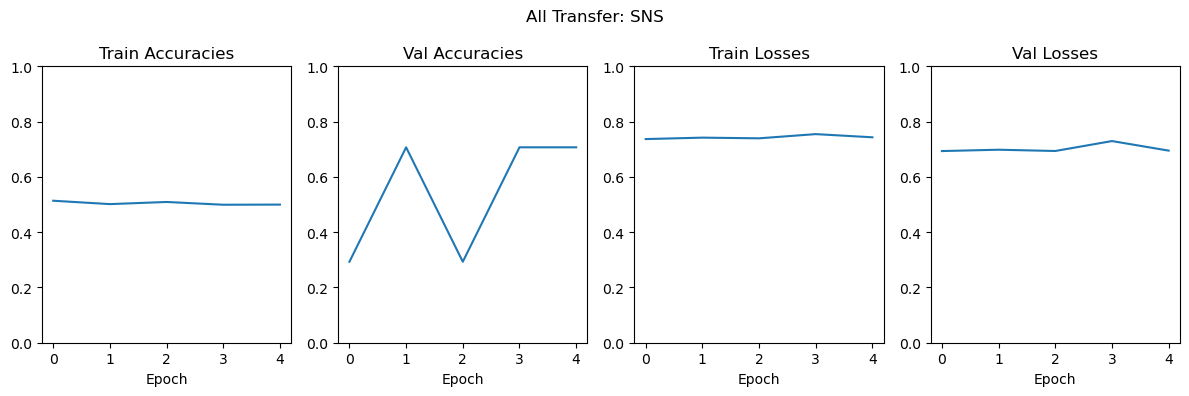

In [122]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("All Transfer: SNS", fontsize=12) 

ax[0].plot(accuracies_2['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies_2['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses_2['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses_2['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("AllTransfer_SNS.png", dpi=300)

plt.show()

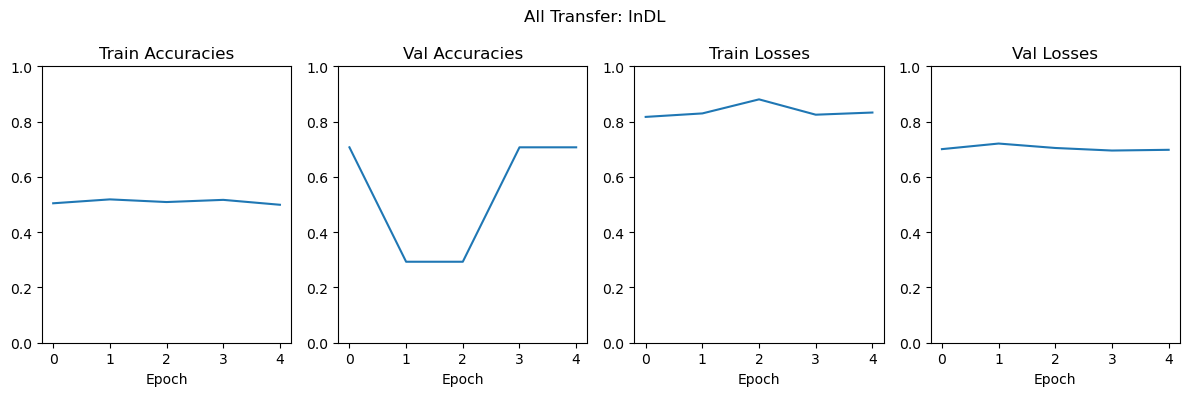

In [127]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("All Transfer: InDL", fontsize=12) 

ax[0].plot(accuracies_3['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies_3['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses_3['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses_3['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("AllTransfer_InDL.png", dpi=300)

plt.show()

In [ ]:
# Batch size 10, 7 epochs
# torch.save(model_ft.state_dict(), 'CIFAR10_InDL_2.pt')
torch.save(model_ft.state_dict(), 'InDL_InDL_1.pt')

Evaluation

In [ ]:
# # Define function for model evaluation
# # Source: ChatGPT; prompt: 'so after training, how do I perform eval'

# def evaluate_model(model, dataloader):
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     acc = correct / total
#     print(f"Evaluation Accuracy: {acc:.4f}")
#     return acc

In [115]:
# CIFAR10_model_eval = evaluate_model(model_ft, dset_loaders['val'])

In [110]:
# SNS_model_eval = evaluate_model(model_ft, dset_loaders['val'])